In [1]:
# bsfs
#chargement du dataset Iris
# divise en ensembles d'entraînement et de test, et utilise un modèle kNN.
# Il applique une sélection séquentielle rétrograde pour choisir les deux meilleurs attributs
# entraîne le modèle avec ces attributs, et évalue sa précision sur les données de test
# enregistre les indices des attributs sélectionnés et la précision obtenue dans un fichier CSV.

In [4]:
import pandas as pd
from sklearn.datasets import load_iris  # Exemple de dataset
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  # Modèle de ML (à choisir)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

iris = load_iris()
X = iris.data  
y = iris.target

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# modèle de machine learning
model = KNeighborsClassifier(n_neighbors=3)  # Exemple de modèle kNN

# Backward Sequential Feature Selection
sfs = SequentialFeatureSelector(model, direction='backward')
sfs.fit(X_train, y_train)

# Étape 4 : Sélectionner les meilleurs attributs
selected_features = sfs.get_support(indices=True)
print(f"Meilleurs attributs sélectionnés (indices) : {selected_features}")

# Filtrer les données d'entraînement et de test avec les meilleurs attributs
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Entraîner le modèle avec les attributs sélectionnés
model.fit(X_train_selected, y_train)

# Prédire et calculer l'accuracy sur les données de test
y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle avec les attributs sélectionnés : {accuracy:.4f}")

# Étape 5 : Enregistrer les résultats dans un fichier CSV
results = {
    'Selected Features Indices': [selected_features],
    'Accuracy': [accuracy]
}
results_df = pd.DataFrame(results)
results_df.to_csv('C:/Users/PC/Downloads/feature_selection_results.csv', index=False)
print("Résultats enregistrés dans 'feature_selection_results.csv'")


Meilleurs attributs sélectionnés (indices) : [1 2]
Précision du modèle avec les attributs sélectionnés : 0.9556
Résultats enregistrés dans 'feature_selection_results.csv'


In [ ]:
recherche exhaustive (methode evaluate_feature_combinations qui prend comme parametres le dataset, le modele, et le score)

In [12]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def evaluate_feature_combinations(data, classifier, metric=accuracy_score):
    # Étape 1 : Encoder les attributs catégoriels en numériques
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    # Séparation des features (X) et de la cible (y)
    X = data.drop('class', axis=1)  # Attributs
    y = data['class']               # Cible

    # Séparation des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Enregistrer les résultats
    results = []
    
    # Variables pour suivre le meilleur score et les attributs associés
    best_score = 0
    best_features = []

    # Étape 2 : Tester toutes les combinaisons possibles d'attributs
    features = X.columns.tolist()

    # Générer toutes les combinaisons de 1 à la totalité des attributs
    for r in range(1, len(features) + 1):
        comb = combinations(features, r)
        for subset in comb:
            # Sélectionner les attributs du sous-ensemble
            X_train_selected = X_train[list(subset)]
            X_test_selected = X_test[list(subset)]
            
            # Entraîner le modèle avec les attributs sélectionnés
            classifier.fit(X_train_selected, y_train)
            
            # Prédire et calculer le score
            y_pred = classifier.predict(X_test_selected)
            score = metric(y_test, y_pred)
            
            # Mettre à jour le meilleur score et les attributs si le score actuel est le meilleur
            if score > best_score:
                best_score = score
                best_features = list(subset)
            
            # Enregistrer les scores et l'encodage des features pour chaque combinaison
            row = {}
            for feature in features:
                row[f'feature{features.index(feature) + 1}'] = 1 if feature in subset else 0
            row['score'] = score
            results.append(row)

    # Calculer gap1 et gap2 pour chaque combinaison basée sur le best_score final
    for result in results:
        result['gap1'] = best_score - result['score']
        result['gap2'] = (result['gap1'] / best_score) if best_score != 0 else 0

    # Convertir les résultats en DataFrame
    results_df = pd.DataFrame(results)

    # Réorganiser les colonnes pour avoir les features en premier, puis le score, gap1, et gap2
    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] + ['score', 'gap1', 'gap2']
    results_df = results_df[ordered_columns]

    # Enregistrer les résultats dans un fichier Excel
    results_df.to_excel('C:/Users/PC/Downloads/feature_combinations_results.xlsx', index=False)
    print("Résultats enregistrés dans 'feature_combinations_results.xlsx'")

    # Afficher la meilleure combinaison et son score
    print(f"\nMeilleure combinaison : {best_features}, Score : {best_score:.4f}")

# Exemple d'utilisation
data = pd.read_csv('C:/Users/PC/Downloads/car+evaluation/car.data', header=None, 
                   names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
classifier = KNeighborsClassifier(n_neighbors=3)
evaluate_feature_combinations(data, classifier, metric=accuracy_score)


Résultats enregistrés dans 'feature_combinations_results.xlsx'

Meilleure combinaison : ['buying', 'maint', 'persons', 'lug_boot', 'safety'], Score : 0.8960


In [ ]:
#sfs with sklaern (forward + backward)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def feature_selection_and_evaluation(dataset_path, model, score_func):
    # Étape 1 : Charger le dataset
    df = pd.read_csv(dataset_path, header=None, 
                     names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
    
    # Étape 2 : Encoder les attributs catégoriels en numériques
    label_encoders = {}
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])
    
    # Séparation des features (X) et de la cible (y)
    X = df.drop('class', axis=1)
    y = df['class']
    
    # Séparation des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Étape 4 : Appliquer le Backward Sequential Feature Selection (SFS)
    sfs = SequentialFeatureSelector(model, direction='backward')
    sfs.fit(X_train, y_train)
    
    # Récupérer les attributs sélectionnés
    selected_features = sfs.get_support(indices=True)
    selected_feature_names = [X.columns[i] for i in selected_features]
    
    # Filtrer les données d'entraînement et de test avec les meilleurs attributs
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    
    # Entraîner le modèle et calculer le score
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    score = score_func(y_test, y_pred)
    
    # Afficher les résultats
    print(f"Meilleurs attributs sélectionnés (indices) : {selected_features}")
    print(f"Meilleurs attributs sélectionnés (noms) : {selected_feature_names}")
    print(f"Score du modèle avec les attributs sélectionnés : {score:.4f}")
    
    # Enregistrer les résultats détaillés dans un fichier CSV
    results = {
        'Selected Features Indices': [selected_features.tolist()],
        'Selected Features Names': [selected_feature_names],
        'Score': [score]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv('C:/Users/PC/Downloads/feature_selection_results_car.csv', index=False)
    print("Résultats enregistrés dans 'feature_selection_results_car.csv'")

    # Enregistrer uniquement le score dans un fichier séparé
    best_score_df = pd.DataFrame([score])  # Crée un DataFrame avec uniquement le score
    best_score_df.to_csv('C:/Users/PC/Downloads/best_score_only1.csv', index=False, header=False)  # Enregistre sans l'en-tête
    print("Meilleur score enregistré dans 'best_score_only.csv'")

# Utilisation de la fonction avec le dataset, le modèle et le score (accuracy)
feature_selection_and_evaluation(
    dataset_path='C:/Users/PC/Downloads/car+evaluation/car.data',
    model=KNeighborsClassifier(n_neighbors=3),
    score_func=accuracy_score
)


Meilleurs attributs sélectionnés (indices) : [0 3 5]
Meilleurs attributs sélectionnés (noms) : ['buying', 'persons', 'safety']
Score du modèle avec les attributs sélectionnés : 0.8054
Résultats enregistrés dans 'feature_selection_results_car.csv'
Meilleur score enregistré dans 'best_score_only.csv'


In [ ]:
# on peut utiliser egalement la librairie mlxtend (sfs + affichege des features + le score)

In [ ]:
# exhaustiveFeatureSelector avec la librairie mlxtend

In [4]:
pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# Charger le dataset "Car Evaluation"
df = pd.read_csv('C:/Users/PC/Downloads/car+evaluation/car.data', header=None, 
                 names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

# Encoder les attributs catégoriels en numériques
label_encoders = {column: LabelEncoder() for column in df.columns}
for column in df.columns:
    df[column] = label_encoders[column].fit_transform(df[column])

# Séparation des features (X) et de la cible (y)
X = df.drop('class', axis=1)  # Attributs
y = df['class']               # Cible

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Définir le modèle de Machine Learning (KNN)
model = KNeighborsClassifier(n_neighbors=3)

# Sélection exhaustive des attributs avec mlxtend
efs = EFS(model, 
          min_features=1,
          max_features=X.shape[1],
          scoring='accuracy',
          print_progress=True,  # Afficher la progression
          cv=5)  # Validation croisée à 5 plis

# Entraîner la méthode de sélection exhaustive
efs = efs.fit(X_train, y_train)

# Afficher les résultats
print(f"Meilleure combinaison : {efs.best_feature_names_}")
print(f"Meilleure précision : {efs.best_score_:.4f}")

# Sélectionner les meilleures caractéristiques
X_train_best = efs.transform(X_train)
X_test_best = efs.transform(X_test)

# Entraîner le modèle avec les meilleures caractéristiques
model.fit(X_train_best, y_train)

# Prédire et évaluer la précision sur le set de test
y_pred = model.predict(X_test_best)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision sur le set de test : {accuracy:.4f}")


C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\s

Meilleure combinaison : ('buying', 'maint', 'persons', 'lug_boot', 'safety')
Meilleure précision : 0.9090
Précision sur le set de test : 0.8960


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

def feature_selection_and_evaluation(dataset_path, model, score_func):
    # Étape 1 : Charger le dataset
    df = pd.read_csv(dataset_path, header=None, 
                     names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
    
    # Étape 2 : Encoder les attributs catégoriels en numériques
    label_encoders = {}
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])
    
    # Séparation des features (X) et de la cible (y)
    X = df.drop('class', axis=1)
    y = df['class']
    
    # Variables pour suivre le meilleur score et les attributs associés
    best_score = 0
    best_features = []
    best_n_splits = 0

    # Boucle pour tester chaque nombre de splits dans la validation croisée
    for n_splits in range(6, 11):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_scores = []

        # Étape 4 : Appliquer le Backward Sequential Feature Selection (SFS)
        sfs = SequentialFeatureSelector(model, direction='backward')
        sfs.fit(X, y)

        # Récupérer les attributs sélectionnés
        selected_features = sfs.get_support(indices=True)
        selected_feature_names = [X.columns[i] for i in selected_features]
        
        # Filtrer les données avec les meilleurs attributs sélectionnés
        X_selected = X.iloc[:, selected_features]

        # Validation croisée
        for train_index, test_index in kf.split(X_selected):
            X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Entraîner le modèle et calculer le score pour chaque pli
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_score = score_func(y_test, y_pred)
            fold_scores.append(fold_score)

        # Calculer la moyenne des scores pour cette configuration
        avg_score = np.mean(fold_scores)
        
        # Afficher les résultats pour chaque configuration de splits
        print(f"Nombre de splits : {n_splits}, Score moyen : {avg_score:.4f}, Attributs : {selected_feature_names}")

        # Vérifier si le nouveau score moyen est meilleur que le meilleur trouvé
        if avg_score > best_score:
            best_score = avg_score
            best_features = selected_feature_names
            best_n_splits = n_splits

    # Enregistrer les meilleurs résultats dans un fichier CSV
    results = {
        'Best Selected Features': [best_features],
        'Best Num Splits': [best_n_splits],
        'Best Score': [best_score]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv('C:/Users/PC/Downloads/feature_selection_results_car_with_cv.csv', index=False)
    print("Résultats enregistrés dans 'feature_selection_results_car_with_cv.csv'")

    # Afficher la meilleure combinaison et son score
    print(f"\nMeilleure combinaison : {best_features}, Nombre de splits : {best_n_splits}, Score moyen : {best_score:.4f}")

# Utilisation de la fonction avec le dataset, le modèle et le score (accuracy)
feature_selection_and_evaluation(
    dataset_path='C:/Users/PC/Downloads/car+evaluation/car.data',
    model=KNeighborsClassifier(n_neighbors=3),
    score_func=accuracy_score
)


Nombre de splits : 6, Score moyen : 0.7523, Attributs : ['buying', 'persons', 'safety']
Nombre de splits : 7, Score moyen : 0.7563, Attributs : ['buying', 'persons', 'safety']
Nombre de splits : 8, Score moyen : 0.7645, Attributs : ['buying', 'persons', 'safety']
Nombre de splits : 9, Score moyen : 0.7558, Attributs : ['buying', 'persons', 'safety']
Nombre de splits : 10, Score moyen : 0.7552, Attributs : ['buying', 'persons', 'safety']
Résultats enregistrés dans 'feature_selection_results_car_with_cv.csv'

Meilleure combinaison : ['buying', 'persons', 'safety'], Nombre de splits : 8, Score moyen : 0.7645


In [ ]:
#Random forest

In [2]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

def feature_selection_and_evaluation(dataset_path, model, score_func):
    # Étape 1 : Charger le dataset
    df = pd.read_csv(dataset_path, header=None, 
                     names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
    
    # Étape 2 : Encoder les attributs catégoriels en numériques
    label_encoders = {}
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])
    
    # Séparation des features (X) et de la cible (y)
    X = df.drop('class', axis=1)
    y = df['class']
    
    # Variables pour suivre le meilleur score et les attributs associés
    best_score = 0
    best_features = []
    best_n_splits = 0

    # Boucle pour tester chaque nombre de splits dans la validation croisée
    for n_splits in range(6, 11):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_scores = []

        # Étape 4 : Appliquer le Backward Sequential Feature Selection (SFS)
        sfs = SequentialFeatureSelector(model, direction='backward')
        sfs.fit(X, y)

        # Récupérer les attributs sélectionnés
        selected_features = sfs.get_support(indices=True)
        selected_feature_names = [X.columns[i] for i in selected_features]
        
        # Filtrer les données avec les meilleurs attributs sélectionnés
        X_selected = X.iloc[:, selected_features]

        # Validation croisée
        for train_index, test_index in kf.split(X_selected):
            X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Entraîner le modèle et calculer le score pour chaque pli
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_score = score_func(y_test, y_pred)
            fold_scores.append(fold_score)

        # Calculer la moyenne des scores pour cette configuration
        avg_score = np.mean(fold_scores)
        
        # Afficher les résultats pour chaque configuration de splits
        print(f"Nombre de splits : {n_splits}, Score moyen : {avg_score:.4f}, Attributs : {selected_feature_names}")

        # Vérifier si le nouveau score moyen est meilleur que le meilleur trouvé
        if avg_score > best_score:
            best_score = avg_score
            best_features = selected_feature_names
            best_n_splits = n_splits

    # Enregistrer les meilleurs résultats dans un fichier CSV
    results = {
        'Best Selected Features': [best_features],
        'Best Num Splits': [best_n_splits],
        'Best Score': [best_score]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv('C:/Users/PC/Downloads/feature_selection_results_car_with_cv.csv', index=False)
    print("Résultats enregistrés dans 'feature_selection_results_car_with_cv.csv'")

    # Afficher la meilleure combinaison et son score
    print(f"\nMeilleure combinaison : {best_features}, Nombre de splits : {best_n_splits}, Score moyen : {best_score:.4f}")

# Utilisation de la fonction avec le dataset, le modèle Random Forest et le score (accuracy)
feature_selection_and_evaluation(
    dataset_path='C:/Users/PC/Downloads/car+evaluation/car.data',
    model=RandomForestClassifier(n_estimators=100, random_state=42),
    score_func=accuracy_score
)


Nombre de splits : 6, Score moyen : 0.8073, Attributs : ['persons', 'lug_boot', 'safety']
Nombre de splits : 7, Score moyen : 0.8061, Attributs : ['persons', 'lug_boot', 'safety']
Nombre de splits : 8, Score moyen : 0.8067, Attributs : ['persons', 'lug_boot', 'safety']
Nombre de splits : 9, Score moyen : 0.8079, Attributs : ['persons', 'lug_boot', 'safety']
Nombre de splits : 10, Score moyen : 0.8061, Attributs : ['persons', 'lug_boot', 'safety']
Résultats enregistrés dans 'feature_selection_results_car_with_cv.csv'

Meilleure combinaison : ['persons', 'lug_boot', 'safety'], Nombre de splits : 9, Score moyen : 0.8079


In [2]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

def feature_selection_and_evaluation(dataset_path, model, score_func):
    # Étape 1 : Charger le dataset
    df = pd.read_csv(dataset_path, header=None, 
                     names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
    
    # Étape 2 : Encoder les attributs catégoriels en numériques
    label_encoders = {}
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])
    
    # Séparation des features (X) et de la cible (y)
    X = df.drop('class', axis=1)
    y = df['class']
    
    # Variables pour suivre le meilleur score et les attributs associés
    best_score = 0
    best_features = []
    best_n_splits = 0

    # Boucle pour tester chaque nombre de splits dans la validation croisée
    for n_splits in range(6, 11):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_scores = []

        # Étape 4 : Appliquer le Backward Sequential Feature Selection (SFS)
        sfs = SequentialFeatureSelector(model, direction='backward')
        sfs.fit(X, y)

        # Récupérer les attributs sélectionnés
        selected_features = sfs.get_support(indices=True)
        selected_feature_names = [X.columns[i] for i in selected_features]
        
        # Filtrer les données avec les meilleurs attributs sélectionnés
        X_selected = X.iloc[:, selected_features]

        # Validation croisée
        for train_index, test_index in kf.split(X_selected):
            X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Entraîner le modèle et calculer le score pour chaque pli
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_score = score_func(y_test, y_pred)
            fold_scores.append(fold_score)

        # Calculer la moyenne des scores pour cette configuration
        avg_score = np.mean(fold_scores)
        
        # Afficher les résultats pour chaque configuration de splits
        print(f"Nombre de splits : {n_splits}, Score moyen : {avg_score:.4f}, Attributs : {selected_feature_names}")

        # Vérifier si le nouveau score moyen est meilleur que le meilleur trouvé
        if avg_score > best_score:
            best_score = avg_score
            best_features = selected_feature_names
            best_n_splits = n_splits

    # Enregistrer les meilleurs résultats dans un fichier CSV
    results = {
        'Best Selected Features': [best_features],
        'Best Num Splits': [best_n_splits],
        'Best Score': [best_score]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv('C:/Users/PC/Downloads/feature_selection_results_car_with_cv.csv', index=False)
    print("Résultats enregistrés dans 'feature_selection_results_car_with_cv.csv'")

    # Afficher la meilleure combinaison et son score
    print(f"\nMeilleure combinaison : {best_features}, Nombre de splits : {best_n_splits}, Score moyen : {best_score:.4f}")

# Utilisation de la fonction avec le dataset, le modèle Random Forest et le score (accuracy)
feature_selection_and_evaluation(
    dataset_path='C:/Users/PC/Downloads/car+evaluation/car.data',
    model=RandomForestClassifier(n_estimators=100, random_state=42),
    score_func=accuracy_score
)


Nombre de splits : 6, Score moyen : 0.8073, Attributs : ['persons', 'lug_boot', 'safety']
Nombre de splits : 7, Score moyen : 0.8061, Attributs : ['persons', 'lug_boot', 'safety']
Nombre de splits : 8, Score moyen : 0.8067, Attributs : ['persons', 'lug_boot', 'safety']
Nombre de splits : 9, Score moyen : 0.8079, Attributs : ['persons', 'lug_boot', 'safety']
Nombre de splits : 10, Score moyen : 0.8061, Attributs : ['persons', 'lug_boot', 'safety']
Résultats enregistrés dans 'feature_selection_results_car_with_cv.csv'

Meilleure combinaison : ['persons', 'lug_boot', 'safety'], Nombre de splits : 9, Score moyen : 0.8079


In [ ]:
#Calcul de gap

Score optimum (recherche exhaustive) : 0.8959537572254336
Score SFS : 0.8053949903660886
Gap : 0.0906


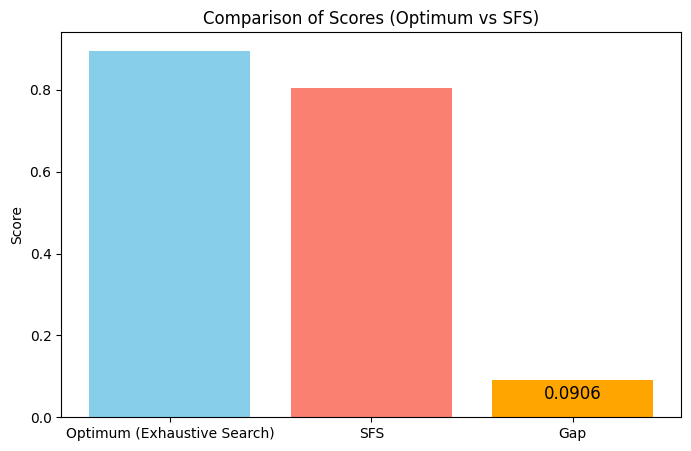

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gap(optimum_path, sfs_path):
    # Lire les scores des fichiers CSV
    optimum_score = pd.read_csv(optimum_path, header=None).iloc[0, 0]
    sfs_score = pd.read_csv(sfs_path, header=None).iloc[0, 0]

    # Calculer le gap entre les scores
    gap = optimum_score - sfs_score

    # Afficher les valeurs et le gap
    print(f"Score optimum (recherche exhaustive) : {optimum_score}")
    print(f"Score SFS : {sfs_score}")
    print(f"Gap : {gap:.4f}")

    # Créer un DataFrame pour les scores et le gap pour faciliter la visualisation
    data = pd.DataFrame({
        'Type': ['Optimum (Exhaustive Search)', 'SFS', 'Gap'],
        'Score': [optimum_score, sfs_score, gap]
    })

    # Plot sous forme d'histogramme
    plt.figure(figsize=(8, 5))
    plt.bar(data['Type'][:-1], data['Score'][:-1], color=['skyblue', 'salmon'])
    plt.title("Comparison of Scores (Optimum vs SFS)")
    plt.ylabel("Score")
    
    # Ajout du gap en annotation
    plt.bar('Gap', data['Score'][2], color='orange')
    plt.text('Gap', data['Score'][2] / 2, f"{gap:.4f}", ha='center', color='black', fontsize=12)
    
    plt.show()

# Chemins vers les fichiers contenant les scores
optimum_path = 'C:/Users/PC/Downloads/best_score_only.csv'
sfs_path = 'C:/Users/PC/Downloads/best_score_only1.csv'

# Appel de la fonction pour afficher le graphique
plot_gap(optimum_path, sfs_path)
